The file outline is:
- load in stu and lds pairs that were trained on della
- filter out cases where the stu didn't fit the lds
- use matrix inversion to try to fit the lds
- use gradient descent on the combination matrix to improve the fit
- use gradient descent on the LDSs and combination matrix to imporve the fit (didn't work)
- xplore how filters are related through dilation

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np
# Save MSE results to JSON
import json

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [3]:
from convolve import convolve, nearest_power_of_two
from stu import STU
from lds_utils import compute_ar_x_preds
from lds import LDS

Unable to import FlashFFTConv: No module named 'flashfftconv'. Falling back to PyTorch implementation.


In [4]:
flash_fft_available = False
dtype = torch.bfloat16 if flash_fft_available else torch.float32

use_hankel_L  = False
phi = torch.tensor(np.load('spectral_filters.npy')).to(device).to(dtype)
seq_len, num_eigh = 8192, 24    
# phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L, device  = device,  dtype = torch.float32)
#I have checked that phi from the file and from get_spectral_filters are the same up to precision and sign
n = nearest_power_of_two(seq_len * 2 - 1, round_up=True)

class Config:
    def __init__(self):
        self.num_eigh = num_eigh
        self.use_hankel_L = use_hankel_L
        self.torch_dtype = dtype
        self.n_embd = 1  # d_in and d_out
        self.seq_len = seq_len
        self.k_u = 0
        self.use_flash_fft = flash_fft_available
        self.use_approx = False

stu_config = Config()


***Let's first load in the LDS and STU pairs that we've trained on Della and filter out the pairs that weren't learned well***

In [6]:
import os
import torch
from pathlib import Path


def load_lds_stu_pairs(directory="../../della/lds_trained"):
    # Convert to Path object for easier path manipulation
    dir_path = Path(directory)
    
    # Dictionary to store pairs temporarily
    pairs_dict = {}
    
    # List all files in directory
    for file in dir_path.glob("*"):
        try:
            if file.suffix == '.pth':
                # Parse filename
                name = file.stem  # Get filename without extension
                
                # Handle different naming patterns
                if 'lds_' in name:
                    # Format like "99462425lds_15.pth"
                    parts = name.split('lds_')
                    prefix = parts[0]
                    number = parts[1]
                    model_type = 'lds'
                elif '_lds_' in name:
                    # Format like "prefix_lds_15.pth"
                    prefix = name.split('_lds_')[0]
                    number = name.split('_')[-1]
                    model_type = 'lds'
                elif 'stu_' in name:
                    # Format like "99462425stu_15.pth"
                    parts = name.split('stu_')
                    prefix = parts[0]
                    number = parts[1]
                    model_type = 'stu'
                elif '_stu_' in name:
                    # Format like "prefix_stu_15.pth"
                    prefix = name.split('_stu_')[0]
                    number = name.split('_')[-1]
                    model_type = 'stu'
                else:
                    # Skip files that don't match expected patterns
                    continue
                    
                # Create key for matching pairs
                key = (prefix, number)
                
                # Initialize dict entry if not exists
                if key not in pairs_dict:
                    pairs_dict[key] = {'lds': None, 'stu': None}
                
                # Load the model state dict
                model_state = torch.load(file)
                pairs_dict[key][model_type] = model_state
        except Exception as e:
            pass
    
    # Convert to list of pairs, only keeping complete pairs
    pairs = []
    for key, models in pairs_dict.items():
        if models['lds'] is not None and models['stu'] is not None:
            pairs.append((models['lds'], models['stu']))
    
    return pairs

# Usage
lds_stu_pairs = load_lds_stu_pairs()

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/1518546640.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(file)


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:

torch.manual_seed(42)
# Define a function to compute MSE between LDS and STU outputs
def compute_mse_for_pairs(pairs, seq_len=100, batch_size=1, input_dim=1):
    results = []
    
    for i, (lds, stu) in enumerate(tqdm(pairs, desc="Computing MSE")):
        # Generate Gaussian input with fixed seed for reproducibility
        
        gaussian_input = torch.randn(batch_size, seq_len, input_dim)
        
        # Set models to evaluation mode
        lds.eval()
        stu.eval()
        
        # Forward pass through both models
        with torch.no_grad():
            lds_output = lds(gaussian_input)
            stu_output = stu(gaussian_input)
            
            # Compute MSE
            mse = F.mse_loss(lds_output, stu_output).item()
            
        results.append({
            'pair_index': i,
            'mse': mse,
            'lds': lds,
            'stu': stu
        })
        
    return results

# Compute MSE for all pairs
mse_results = compute_mse_for_pairs(lds_stu_pairs, 8192)


Computing MSE: 100%|██████████| 34198/34198 [32:25<00:00, 17.58it/s] 


In [8]:


# Create dictionary mapping index to MSE value
mse_dict = {result['pair_index']: result['mse'] for result in mse_results}

# Save to JSON file
with open('lds_stu_mse.json', 'w') as f:
    json.dump(mse_dict, f)


NameError: name 'mse_results' is not defined

In [9]:
# Load MSE results from JSON
with open('lds_stu_mse.json', 'r') as f:
    mse_dict = json.load(f)

# Reconstruct mse_results dataset
mse_results = []
for pair_index, mse in mse_dict.items():
    mse_results.append({
        'pair_index': int(pair_index),
        'mse': mse,
        'lds': lds_stu_pairs[int(pair_index)][0],
        'stu': lds_stu_pairs[int(pair_index)][1]
    })


Total pairs: 34198
Filtered pairs with low MSE: 19616


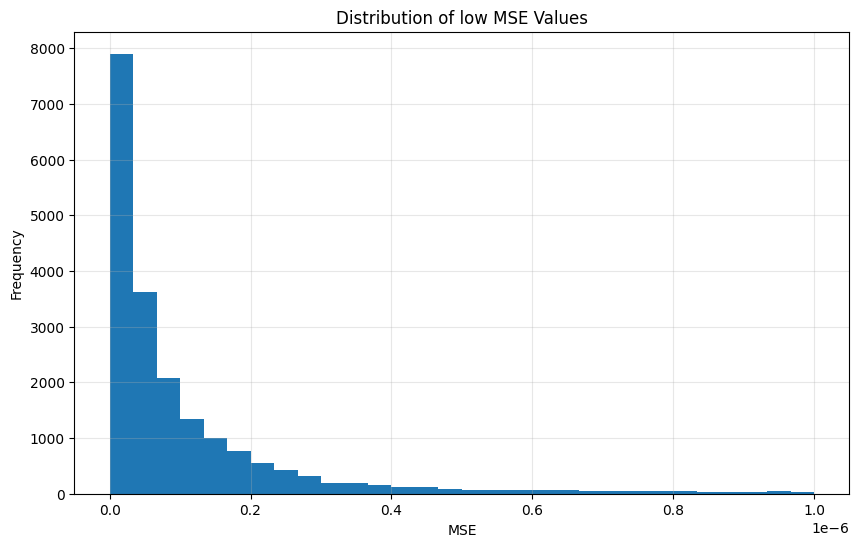

In [10]:
# Filter pairs with MSE less than threshold
threshold = 1e-6
filtered_pairs = []
for result in mse_results:
    if result['mse'] < threshold:
        filtered_pairs.append((result['lds'], result['stu']))

print(f"Total pairs: {len(mse_results)}")
print(f"Filtered pairs with low MSE: {len(filtered_pairs)}")

# Create a new list of MSE values for the filtered pairs
filtered_mse = [result['mse'] for result in mse_results if result['mse'] < threshold]

# Plot histogram of filtered MSE values if there are any
if filtered_mse:
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_mse, bins=30)
    plt.title('Distribution of low MSE Values')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No pairs with MSE < 1e-5 found.")


In [11]:
def gen_lds_impulse(lds, seq_len=seq_len):
    # Start with ones and multiply A from second position onwards
    a = torch.ones(seq_len)
    a[1:] = lds.A.item()  # Fill all positions after first with A
    a_powers = torch.cumprod(a, dim=0)  # [1, A, A², A³, ...]
    
    # Compute impulse response: C * (A^t) * B
    lds_impulse = lds.C.item() * a_powers * lds.B.item()
    
    return lds_impulse.cpu()

phi_n = phi.data.cpu().numpy()

def gen_stu_impulse(stu, seq_len = seq_len):
    alt_sign = lambda x: x * np.array([1, -1] * (seq_len//2))
    pos_coef = stu.M_phi_plus.data.cpu().numpy()[:, 0,0]
    neg_coef = stu.M_phi_minus.data.cpu().numpy()[:,0,0]
    impulse = np.sum(phi_n*pos_coef, axis = -1) + alt_sign(np.sum(phi_n*neg_coef, axis = -1))
    return impulse

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


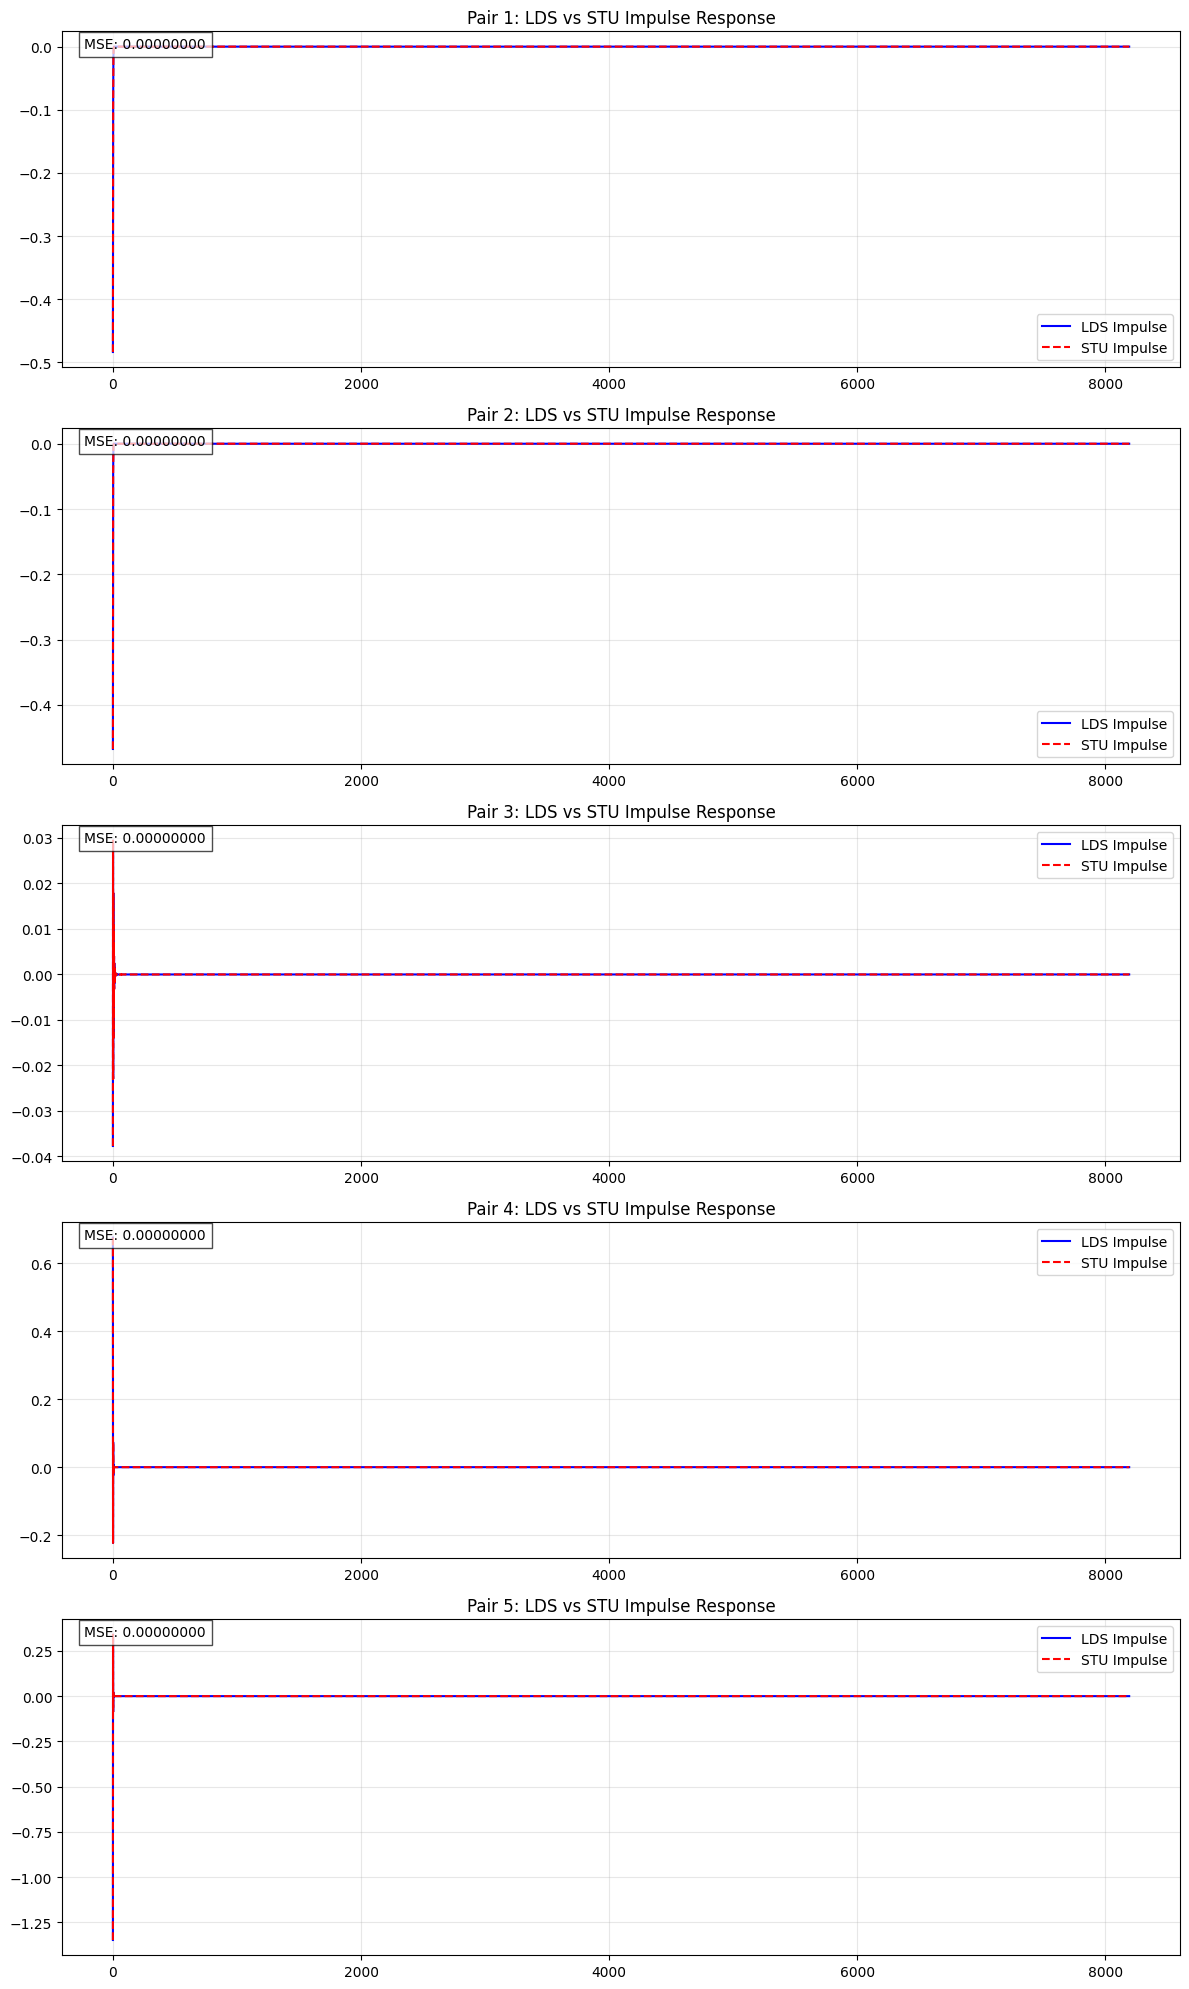

In [12]:
# Sample 20 random pairs from the filtered pairs
import random
import numpy as np
import matplotlib.pyplot as plt

# Make sure we have pairs to sample
if filtered_pairs:
    # Sample min(20, available pairs) to avoid error if we have fewer than 20 pairs
    sample_size = min(5, len(filtered_pairs))
    sampled_pairs = random.sample(filtered_pairs, sample_size)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(sample_size, 1, figsize=(12, 4*sample_size))
    
    # If only one pair is sampled, axes won't be an array
    if sample_size == 1:
        axes = [axes]
    
    # Plot each sampled pair
    for i, (lds, stu) in enumerate(sampled_pairs):
        # Generate impulse responses
        lds_impulse = gen_lds_impulse(lds)
        stu_impulse = gen_stu_impulse(stu)
        
        # Convert to numpy for plotting if needed
        if isinstance(lds_impulse, torch.Tensor):
            lds_impulse = lds_impulse.detach().numpy()
        
        # Plot on the corresponding subplot
        axes[i].plot(lds_impulse, label='LDS Impulse', color='blue')
        axes[i].plot(stu_impulse, label='STU Impulse', color='red', linestyle='--')
        axes[i].set_title(f'Pair {i+1}: LDS vs STU Impulse Response')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Calculate MSE for this pair
        mse = np.mean((lds_impulse - stu_impulse)**2)
        axes[i].text(0.02, 0.95, f'MSE: {mse:.8f}', transform=axes[i].transAxes, 
                     bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
else:
    print("No filtered pairs available to sample.")


In [13]:
# Calculate the maximum eigenvalue of each LDS in the filtered list
import numpy as np
import matplotlib.pyplot as plt

if filtered_pairs:
    # Extract LDS parameters from filtered pairs
    lds_params = [lds for lds, _ in filtered_pairs]
    
    max_eigenvalues = max([np.max(np.abs(lds.A.data.item())) for lds in lds_params])
    print(max_eigenvalues)


0.9999650120735168


In [16]:
# Reconstruct filters from LDS-STU pairs using pseudoinverse approach
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tqdm


print(f"Attempting to reconstruct filters from {len(filtered_pairs)} LDS-STU pairs")

# Extract LDS and STU parameters from filtered pairs
lds_params = [lds for lds, _ in filtered_pairs]
stu_params = [stu for _, stu in filtered_pairs]

# Generate impulse responses for all pairs, could probably do this faster by stacking
with torch.no_grad():
    lds_impulses = np.array([gen_lds_impulse(lds).detach() for lds in tqdm.tqdm(lds_params, desc="Generating LDS impulses")])
    stu_impulses = np.array([gen_stu_impulse(stu) for stu in tqdm.tqdm(stu_params, desc="Generating STU impulses")])

# Convert to torch tensors
lds_impulses_tensor = torch.tensor(lds_impulses, dtype=torch.float)

# Assuming we have the combined weights from the STU parameters
# We'll construct combined_weights from STU parameters

#8 min with 8785 pairs


Attempting to reconstruct filters from 19616 LDS-STU pairs


Generating LDS impulses:   0%|          | 0/19616 [00:00<?, ?it/s]

Generating STU impulses: 100%|██████████| 19616/19616 [00:05<00:00, 3458.00it/s]


In [20]:
# Calculate the rank of the LDS impulses matrix
# First, check the shape of the LDS impulses tensor
print(f"Shape of lds_impulses_tensor: {lds_impulses_tensor.shape}")

# Convert to numpy for rank calculation
lds_impulses_np = lds_impulses_tensor.numpy()

# Calculate the rank using numpy's matrix_rank function
from numpy.linalg import matrix_rank
rank = matrix_rank(lds_impulses_np)

print(f"Rank of LDS impulses matrix: {rank}")
print(f"This means that out of {lds_impulses_np.shape[0]} LDS impulse vectors, only {rank} are linearly independent.")

# Visualize the singular values to understand the effective rank
u, s, vh = np.linalg.svd(lds_impulses_np, full_matrices=False)
plt.figure(figsize=(10, 6))
plt.semilogy(s, 'o-')
plt.title('Singular Values of LDS Impulses Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True)
plt.show()

# Plot the cumulative explained variance
explained_variance = np.cumsum(s) / np.sum(s)
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

# Find how many components are needed to explain 95% of variance
components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components needed to explain 95% of variance: {components_95}")

#takes 3 min with 8785 pairs


Shape of lds_impulses_tensor: torch.Size([19616, 8192])


KeyboardInterrupt: 

**Now lets use the equation lds_impulse ≈ M @ phi to reach phi = M^(-1) @ lds_impulse **

In [17]:
alternating_signs = np.array([1, -1] * (seq_len//2))
phi_n_alternating = phi_n * alternating_signs[:, np.newaxis]
phi_n_combined = np.concatenate([phi_n, phi_n_alternating], axis=1)  # Shape: (1024, 40)

In [18]:
# For each STU, combine M_phi_plus and M_phi_minus
combined_weights = []
for stu in stu_params:
    # Get M_phi_plus and M_phi_minus from STU model
    M_phi_plus = stu.M_phi_plus.detach().cpu().numpy()[:,0,0]
    M_phi_minus = stu.M_phi_minus.detach().cpu().numpy()[:,0,0]
    
    # Concatenate the weights
    combined = np.concatenate([M_phi_plus, M_phi_minus], axis=0)
    combined_weights.append(combined)

# Stack all combined weights into a single array
combined_weights = np.stack(combined_weights)
combined_weights.shape

(19616, 48)

In [21]:
import tqdm

# Run 10000 times and keep track of best indices
best_mse = float('inf')
best_indices = None

for _ in tqdm.tqdm(range(100000)):
    # Sample 500 random indices between 0 and 19616
    sampled_indices = np.random.choice(19616, size=100, replace=False)
    
    # Subsample from lds_impulses_tensor and combined_weights using these indices
    lds_impulses_sampled = lds_impulses_tensor[sampled_indices]
    combined_weights_sampled = combined_weights[sampled_indices]
    
    # Calculate MSE for this sample
    combined_weights_sampled_pinv = np.linalg.pinv(combined_weights_sampled.T)
    phi_n_approx = np.matmul(lds_impulses_sampled.T, combined_weights_sampled_pinv)
    mse = F.mse_loss(torch.tensor(phi_n_combined[:, :24]), torch.tensor(phi_n_approx[:, :24])) #only focusing on first 24 filters
    
    # Update best if current is better
    if mse < best_mse:
        best_mse = mse
        print("New Best:", mse)
        best_indices = sampled_indices

print(f"Best MSE found: {best_mse}")


  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2439047495.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_approx = np.matmul(lds_impulses_sampled.T, combined_weights_sampled_pinv)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2439047495.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(phi_n_combined[:, :24]), torch.tensor(phi_n_approx[:, :24])) #only focusing on first 24 filters
  0%|          | 114/100000 [00:00<02:51, 580.97it/s]

New Best: tensor(1.6634e-08, dtype=torch.float64)
New Best: tensor(1.0775e-08, dtype=torch.float64)
New Best: tensor(8.8851e-09, dtype=torch.float64)
New Best: tensor(1.8394e-09, dtype=torch.float64)
New Best: tensor(5.0300e-10, dtype=torch.float64)


  0%|          | 490/100000 [00:00<02:41, 617.14it/s]

New Best: tensor(4.8062e-10, dtype=torch.float64)


  1%|          | 940/100000 [00:01<02:06, 780.98it/s]

New Best: tensor(3.5448e-10, dtype=torch.float64)


  2%|▏         | 1949/100000 [00:02<01:38, 997.90it/s] 

New Best: tensor(3.3808e-10, dtype=torch.float64)


  4%|▍         | 4314/100000 [00:04<01:37, 982.92it/s] 

New Best: tensor(2.7956e-10, dtype=torch.float64)


 10%|▉         | 9667/100000 [00:10<01:27, 1037.03it/s]

New Best: tensor(2.2139e-10, dtype=torch.float64)


 23%|██▎       | 23133/100000 [00:23<01:15, 1021.33it/s]

New Best: tensor(2.0660e-10, dtype=torch.float64)


 25%|██▍       | 24782/100000 [00:24<01:12, 1034.33it/s]

New Best: tensor(6.2727e-11, dtype=torch.float64)


100%|██████████| 100000/100000 [01:40<00:00, 998.28it/s]

Best MSE found: 6.272743752620707e-11


In [22]:
import copy

indices = copy.deepcopy(best_indices)
best_mse = float('inf')

# Calculate initial MSE
lds_impulses_sampled = lds_impulses_tensor[indices]
combined_weights_sampled = combined_weights[indices]
combined_weights_sampled_pinv = np.linalg.pinv(combined_weights_sampled.T)
phi_n_approx = np.matmul(lds_impulses_sampled.T, combined_weights_sampled_pinv)
best_mse = F.mse_loss(torch.tensor(phi_n_combined[:, :24]), torch.tensor(phi_n_approx[:, :24]))

print(f"Initial MSE with {len(indices)} coordinates: {best_mse:.2e}")

# Greedily add coordinates that minimize MSE
remaining_indices = list(set(range(19616)) - set(indices))
num_to_add = 400  # Add 400 more coordinates

for i in tqdm.tqdm(range(num_to_add)):
    current_best_mse = float('inf')
    best_new_idx = None
    
    # Try adding each remaining coordinate and keep the best one
    for j, idx in enumerate(np.random.choice(remaining_indices, size=min(1000, len(remaining_indices)), replace=False)):
        # Add this index to current set
        test_indices = np.append(indices, idx)
        
        
        # Calculate MSE with this additional coordinate
        lds_impulses_test = lds_impulses_tensor[test_indices]
        combined_weights_test = combined_weights[test_indices]
        combined_weights_test_pinv = np.linalg.pinv(combined_weights_test.T)
        phi_n_test = np.matmul(lds_impulses_test.T, combined_weights_test_pinv)
        test_mse = F.mse_loss(torch.tensor(phi_n_combined[:, :24]), torch.tensor(phi_n_test[:, :24]))
        
        if test_mse < current_best_mse:
            current_best_mse = test_mse
            best_new_idx = idx
    
    # Add the best new coordinate found
    if best_new_idx is not None:
        indices = np.append(indices, best_new_idx)
        remaining_indices.remove(best_new_idx)
        best_mse = current_best_mse
        
        if (i + 1) % 20 == 0:
            print(f"After adding {i+1} coordinates, MSE: {best_mse:.2e}")




/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2927444789.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_approx = np.matmul(lds_impulses_sampled.T, combined_weights_sampled_pinv)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2927444789.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_mse = F.mse_loss(torch.tensor(phi_n_combined[:, :24]), torch.tensor(phi_n_approx[:, :24]))


Initial MSE with 100 coordinates: 6.27e-11


  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2927444789.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_test = np.matmul(lds_impulses_test.T, combined_weights_test_pinv)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2927444789.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mse = F.mse_loss(torch.tensor(phi_n_combined[:, :24]), torch.tensor(phi_n_test[:, :24]))
  5%|▌         | 20/400 [00:16<05:15,  1.20it/s]

After adding 20 coordinates, MSE: 2.35e-12


 10%|█         | 40/400 [00:34<05:46,  1.04it/s]

After adding 40 coordinates, MSE: 1.52e-12


 15%|█▌        | 60/400 [00:57<06:23,  1.13s/it]

After adding 60 coordinates, MSE: 1.24e-12


 20%|██        | 80/400 [01:22<06:42,  1.26s/it]

After adding 80 coordinates, MSE: 1.14e-12


 25%|██▌       | 100/400 [01:49<07:08,  1.43s/it]

After adding 100 coordinates, MSE: 1.06e-12


 26%|██▋       | 105/400 [01:58<05:33,  1.13s/it]


KeyboardInterrupt: 

In [23]:
print(f"\nFinal MSE with {len(indices)} coordinates: {best_mse:.2e}")

lds_impulses_final = lds_impulses_tensor[indices]
combined_weights_final = combined_weights[indices]
combined_weights_final_pinv = np.linalg.pinv(combined_weights_final.T)
phi_n_approx = np.matmul(lds_impulses_final.T, combined_weights_final_pinv)


Final MSE with 205 coordinates: 1.05e-12


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/3102530697.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_approx = np.matmul(lds_impulses_final.T, combined_weights_final_pinv)


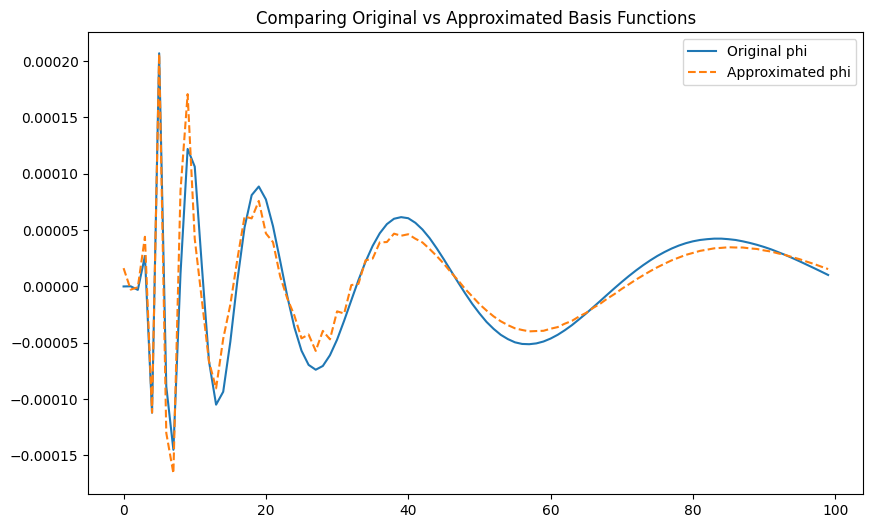

MSE between original and approximated phi: 1.05e-12


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/3448786934.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(phi_n_combined)[:, :24], torch.tensor(phi_n_approx)[:, :24])


In [24]:
# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined)[:, :24], torch.tensor(phi_n_approx)[:, :24])
print(f"MSE between original and approximated phi: {mse:.2e}")


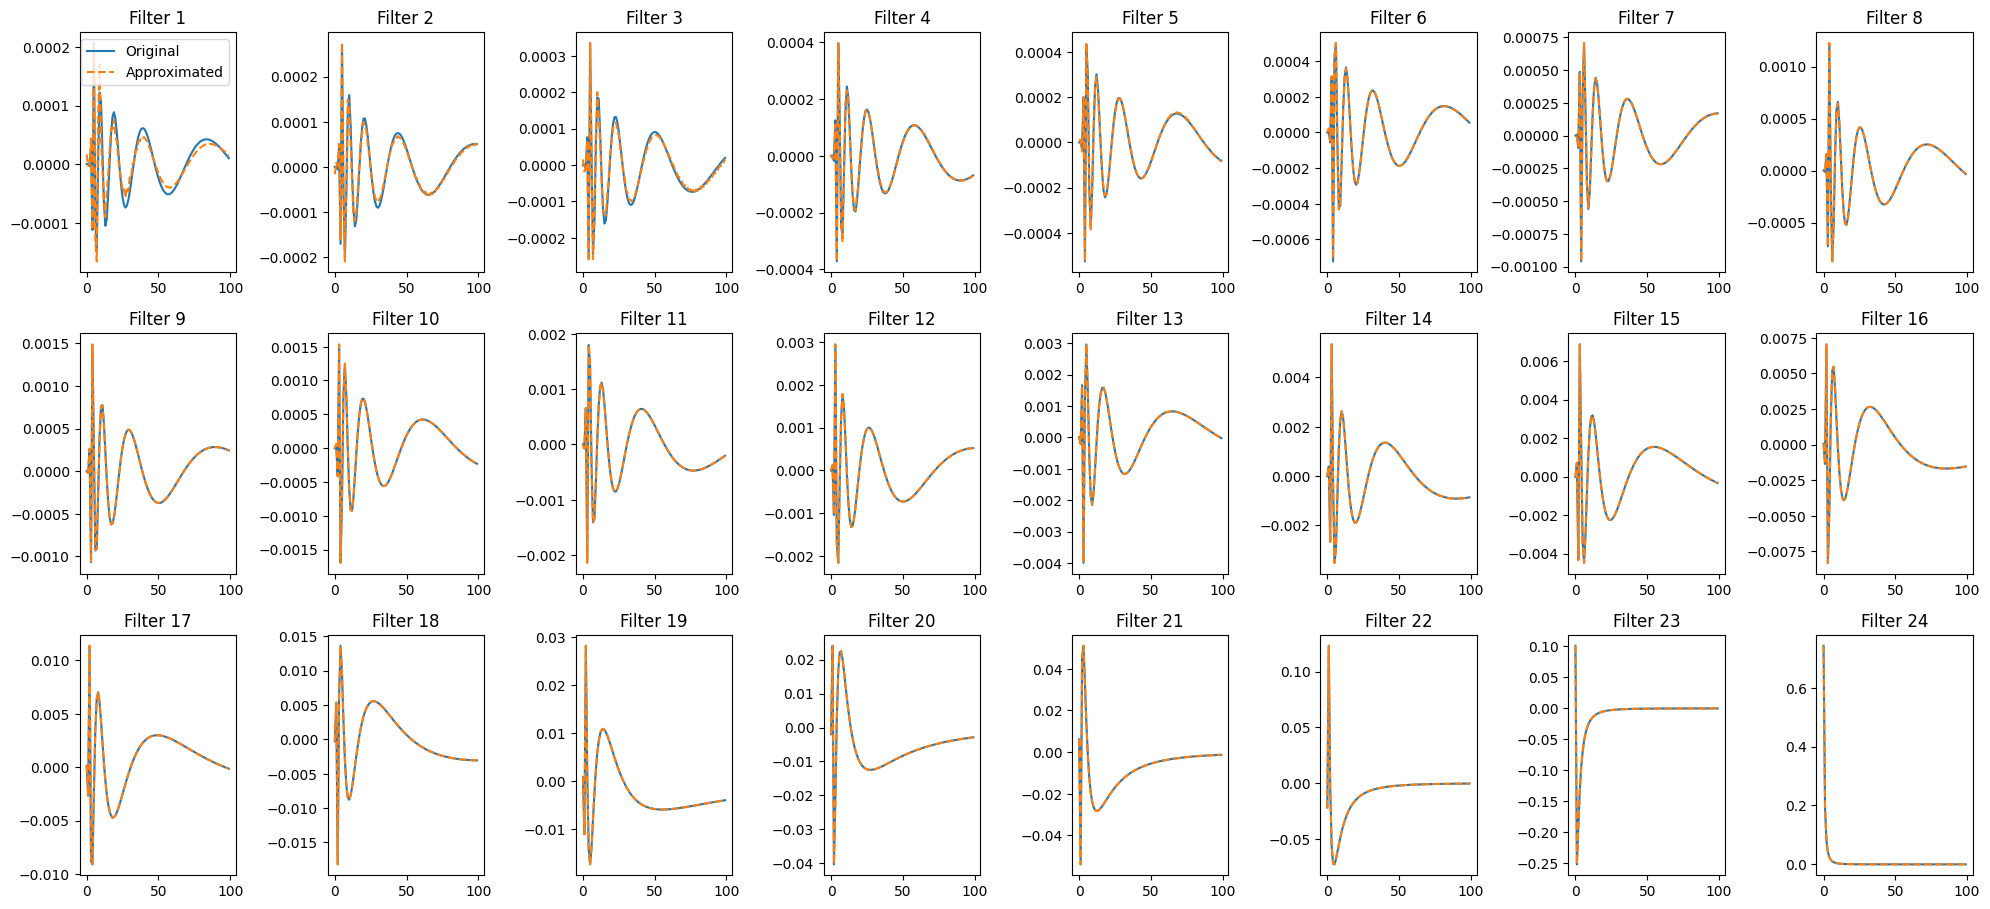

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/1717794009.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(phi_n_approx[:, i])


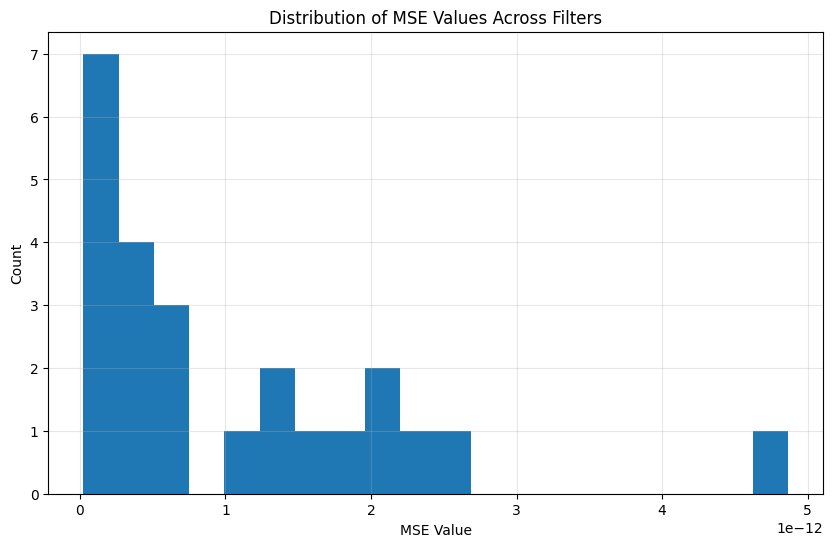

Mean MSE across filters: 1.05e-12
Median MSE across filters: 5.54e-13
Min MSE: 2.36e-14, Max MSE: 4.87e-12


In [25]:
# Plot all 48 filters to compare original vs approximated phi
num_filters = phi_n_combined.shape[1]  # Should be 48 based on previous output
num_rows = (num_filters + 7) // 8  # Arrange in 8 columns

plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters//2):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_approx[:100, i], '--', label='Approximated')
    plt.title(f'Filter {i+1}')
    if i == 0:  # Only show legend on the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate MSE for each filter individually
filter_mses = []
for i in range(num_filters//2):
    filter_mse = F.mse_loss(
        torch.tensor(phi_n_combined[:, i]), 
        torch.tensor(phi_n_approx[:, i])
    )
    filter_mses.append(filter_mse.item())

# Plot histogram of per-filter MSE values
plt.figure(figsize=(10, 6))
plt.hist(filter_mses, bins=20)
plt.xlabel('MSE Value')
plt.ylabel('Count')
plt.title('Distribution of MSE Values Across Filters')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print(f"Mean MSE across filters: {np.mean(filter_mses):.2e}")
print(f"Median MSE across filters: {np.median(filter_mses):.2e}")
print(f"Min MSE: {np.min(filter_mses):.2e}, Max MSE: {np.max(filter_mses):.2e}")


***Now lets use gradient descent to improve this fit***

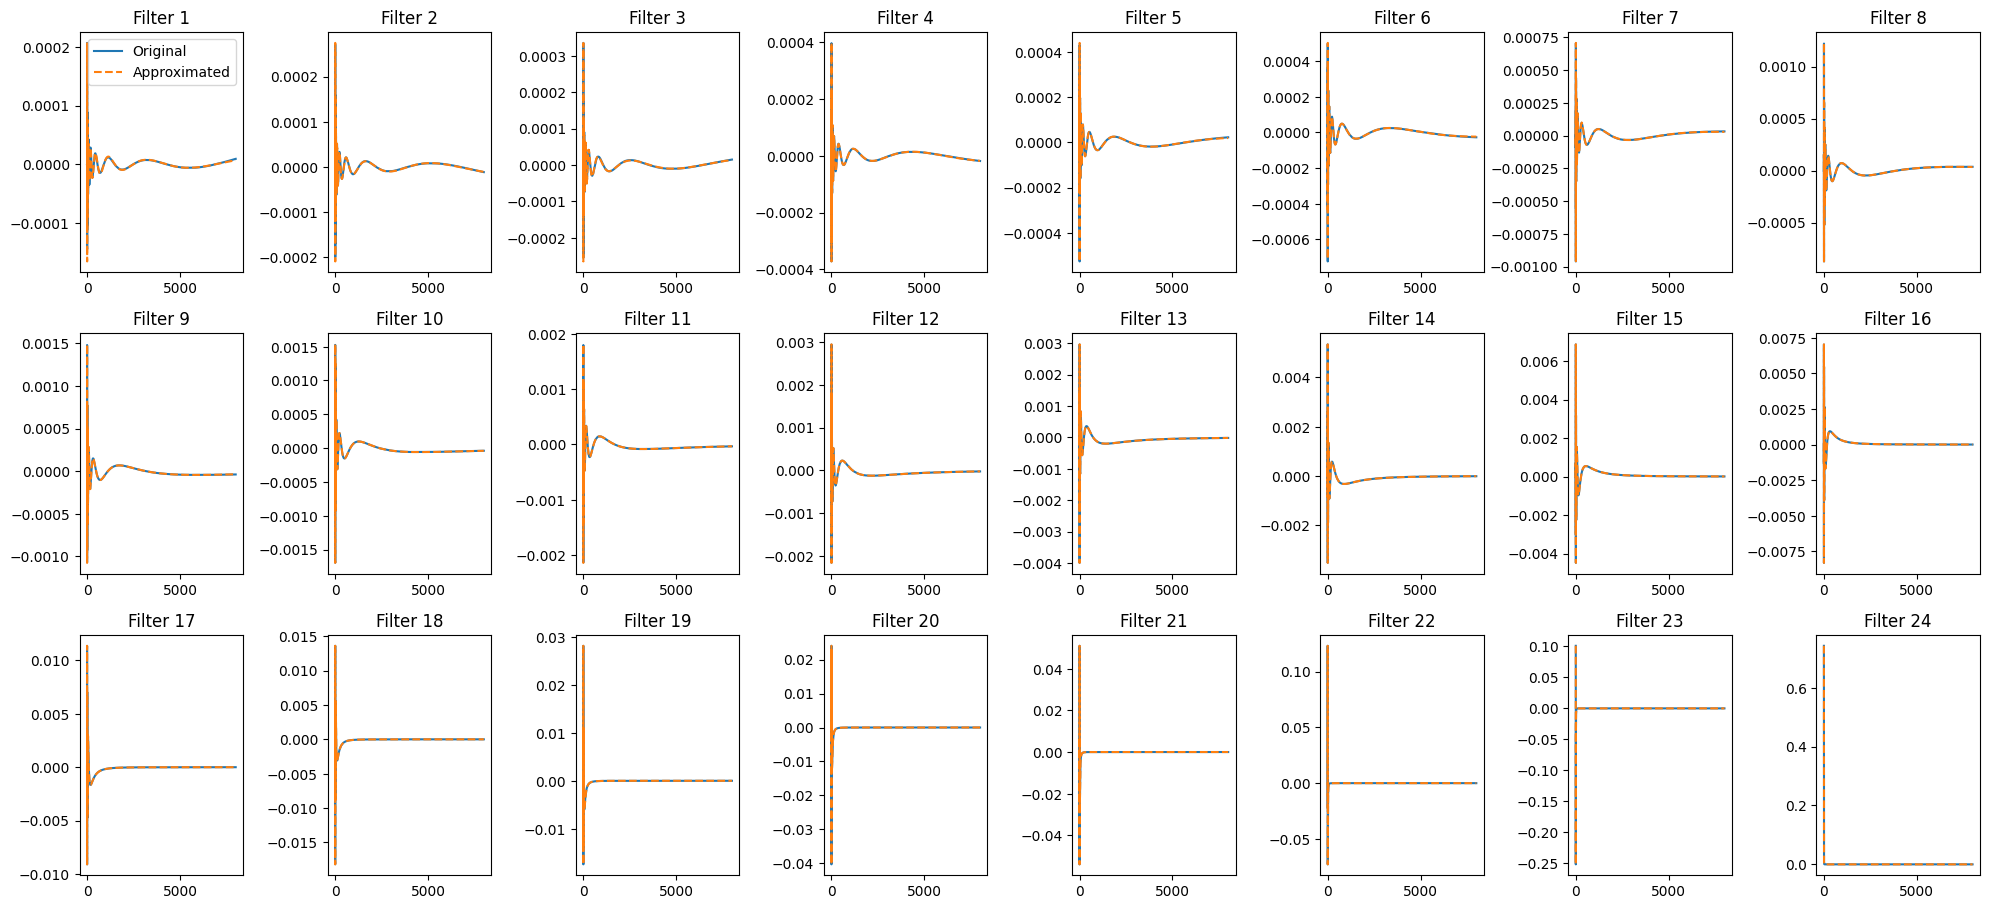

In [26]:
plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters//2):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:8000, i], label='Original')
    plt.plot(phi_n_approx[:8000, i], '--', label='Approximated')
    plt.title(f'Filter {i+1}')
    if i == 0:  # Only show legend on the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Perform gradient descent to improve the reconstruction
print("Starting gradient descent optimization...")

# Convert to PyTorch tensors
phi_n_combined_tensor = torch.tensor(phi_n_combined, dtype=torch.float32)
combined_weights_pinv_tensor = torch.tensor(combined_weights_final_pinv, dtype=torch.float32, requires_grad=True)

# Initialize optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam([combined_weights_pinv_tensor], lr=learning_rate)

# Training parameters
num_steps = 5000000
print_interval = 5000

# Training loop
losses = []
for step in range(num_steps + 1):
    # Forward pass: compute approximated phi
    phi_n_approx_tensor = torch.matmul(lds_impulses_final.T, combined_weights_pinv_tensor)
    
    # Compute loss
    loss = F.mse_loss(phi_n_approx_tensor[:, :24], phi_n_combined_tensor[:, :24])
    
    # Store loss
    losses.append(loss.item())
    
    # Print progress
    if step % print_interval == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss.item():.2e}")
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Starting gradient descent optimization...
Step 0/5000000, Loss: 1.05e-12
Step 5000/5000000, Loss: 9.72e-13
Step 10000/5000000, Loss: 9.68e-13
Step 15000/5000000, Loss: 9.70e-13
Step 20000/5000000, Loss: 9.67e-13
Step 25000/5000000, Loss: 9.64e-13
Step 30000/5000000, Loss: 9.58e-13
Step 35000/5000000, Loss: 9.56e-13


KeyboardInterrupt: 

MSE after optimization: 9.61e-13
Improvement factor: 1.09x


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2699984025.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(phi_n_improved)[:, :24]


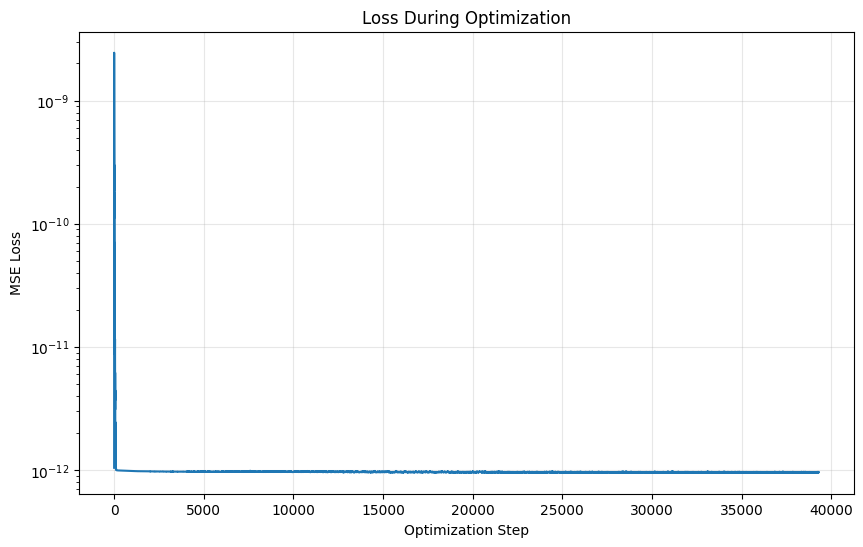

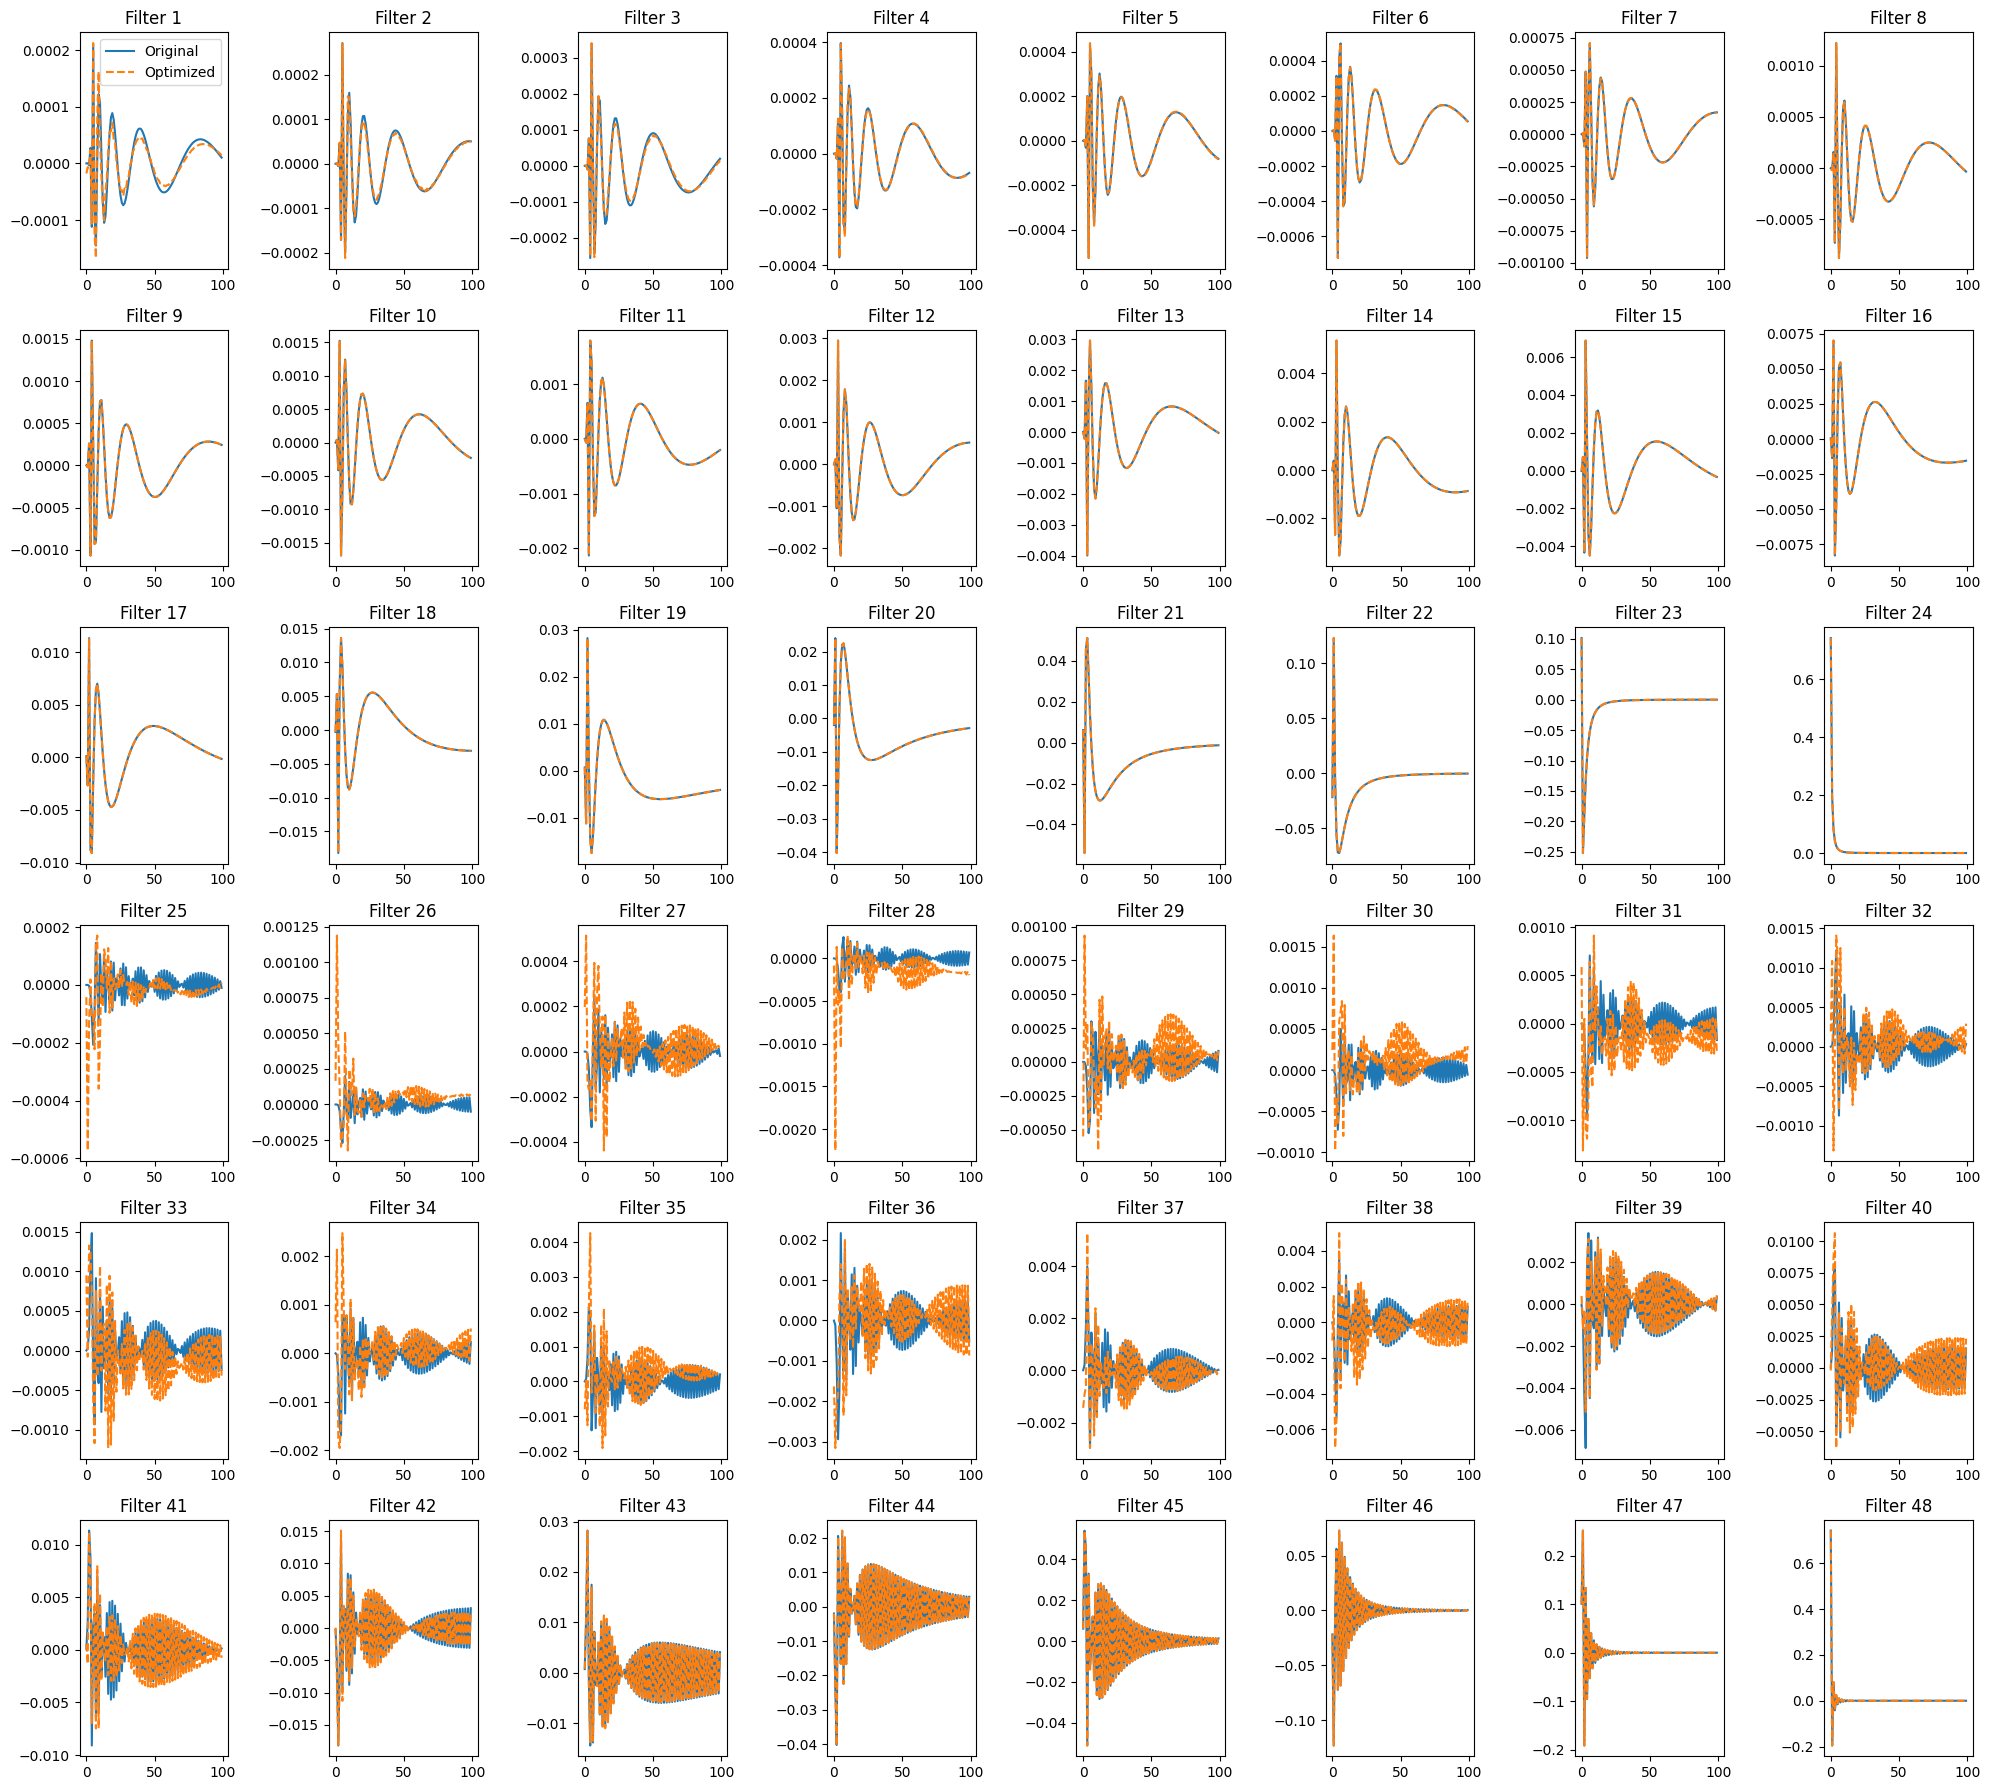

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2699984025.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(phi_n_improved[:, i])


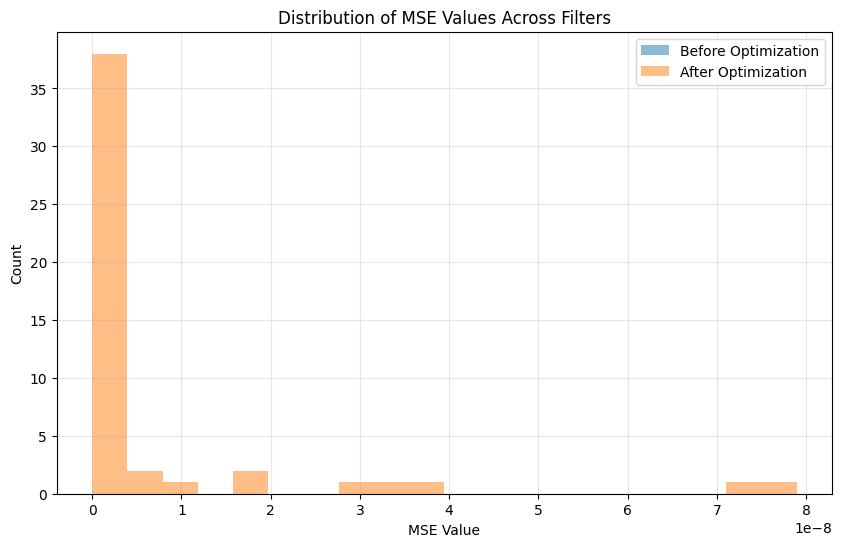

In [28]:

# Compute the improved approximation
phi_n_improved = torch.matmul(lds_impulses_final.T, combined_weights_pinv_tensor).detach()

# Calculate MSE between original and improved approximation
improved_mse = F.mse_loss(
    torch.tensor(phi_n_combined)[:, :24], 
    torch.tensor(phi_n_improved)[:, :24]
).item()

print(f"MSE after optimization: {improved_mse:.2e}")
print(f"Improvement factor: {mse / improved_mse:.2f}x")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Optimization Step')
plt.ylabel('MSE Loss')
plt.title('Loss During Optimization')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Plot comparison of filters before and after optimization
plt.figure(figsize=(20, num_rows * 3))

for i in range(num_filters):
    plt.subplot(num_rows, 8, i + 1)
    plt.plot(phi_n_combined[:100, i], label='Original')
    plt.plot(phi_n_improved[:100, i], '--', label='Optimized')
    plt.title(f'Filter {i+1}')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate per-filter MSE for the improved approximation
improved_filter_mses = []
for i in range(num_filters):
    filter_mse = F.mse_loss(
        torch.tensor(phi_n_combined[:, i]), 
        torch.tensor(phi_n_improved[:, i])
    )
    improved_filter_mses.append(filter_mse.item())

# Plot histogram comparing MSE before and after optimization
plt.figure(figsize=(10, 6))
plt.hist(filter_mses, bins=20, alpha=0.5, label='Before Optimization')
plt.hist(improved_filter_mses, bins=20, alpha=0.5, label='After Optimization')
plt.xlabel('MSE Value')
plt.ylabel('Count')
plt.title('Distribution of MSE Values Across Filters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


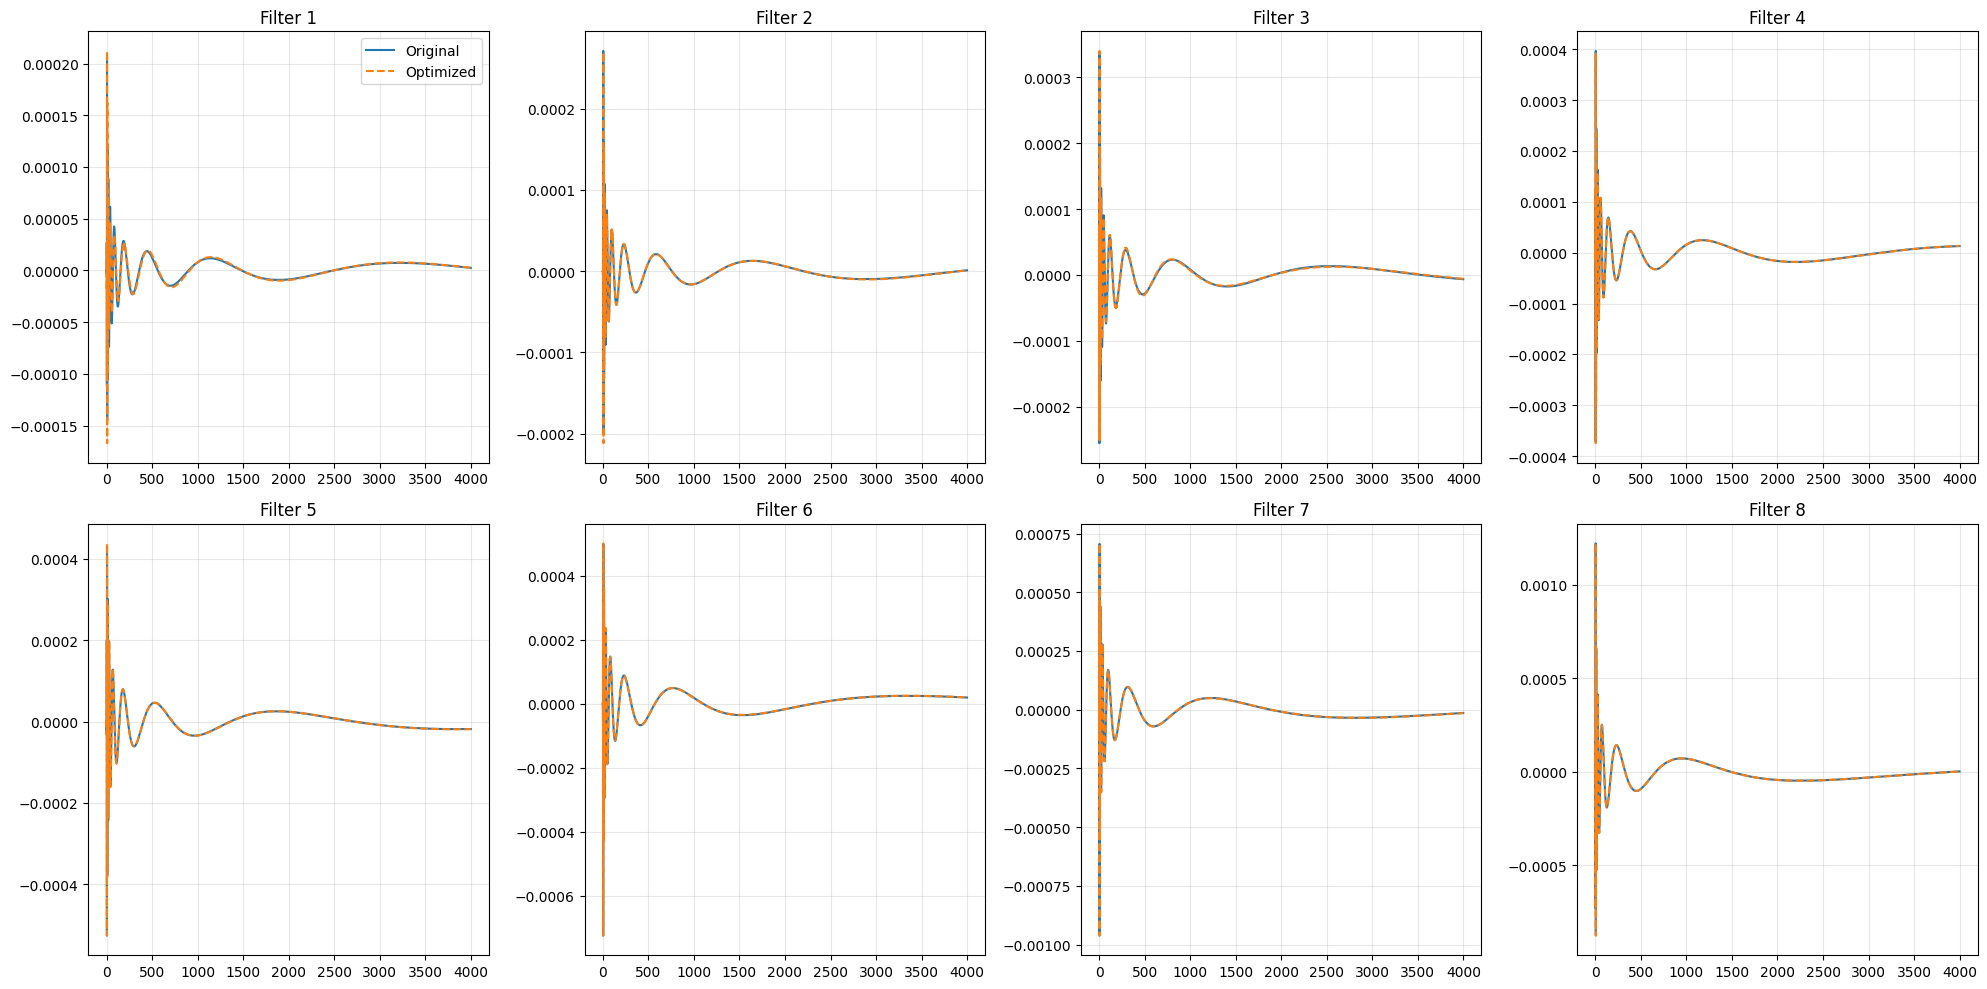

In [29]:
# Plot the first 8 filters and their reconstruction
plt.figure(figsize=(20, 10))

for i in range(8):  # Only plot the first 8 filters
    plt.subplot(2, 4, i + 1)
    plt.plot(phi_n_combined[:4000, i], label='Original')
    plt.plot(phi_n_improved[:4000, i], '--', label='Optimized')
    plt.title(f'Filter {i+1}')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

#


In [30]:
# Create a directory to save the LDS and weights data
import os
import numpy as np
import torch

# Create the directory if it doesn't exist
save_dir = f"fit_filters_{len(indices)}"  # Changed to use len(indices)
os.makedirs(save_dir, exist_ok=True)

# Save the combined weights tensor
np.save(os.path.join(save_dir, "combined_weights_pinv.npy"), combined_weights_pinv_tensor.detach().cpu().numpy())
torch.save(combined_weights_pinv_tensor, os.path.join(save_dir, "combined_weights_pinv.pth"))

# Save the indices used for selection
np.save(os.path.join(save_dir, "selected_indices.npy"), indices)

# Save the LDS models that were selected (using indices)
for i, idx in enumerate(indices):
    torch.save(lds_params[idx].state_dict(), os.path.join(save_dir, f"lds_model_{i}.pth"))

print(f"Saved combined weights (shape: {combined_weights_pinv_tensor.shape}), indices (shape: {indices.shape}), and {len(indices)} selected LDS models to {save_dir}/ in both .npy and .pth formats")

Saved combined weights (shape: torch.Size([205, 48])), indices (shape: (205,)), and 205 selected LDS models to fit_filters_205/ in both .npy and .pth formats


In [31]:
# Extract A, B, and C matrices from selected LDS models
A_matrices = []
B_matrices = []
C_matrices = []

# Only extract from LDS models that were selected
for idx in indices:
    lds = lds_params[idx]
    # Extract parameters from each selected LDS model
    A_matrices.append(lds.A.detach().clone())
    B_matrices.append(lds.B.detach().clone())
    C_matrices.append(lds.C.detach().clone())

# Stack all matrices
stacked_A = torch.stack(A_matrices)
stacked_B = torch.stack(B_matrices)
stacked_C = torch.stack(C_matrices)

# Print shapes to verify
print(f"Stacked A shape: {stacked_A.shape}")
print(f"Stacked B shape: {stacked_B.shape}")
print(f"Stacked C shape: {stacked_C.shape}")

# Combine B and C matrices
BC = (stacked_B * stacked_C).reshape(-1)
A = stacked_A.reshape(-1)


Stacked A shape: torch.Size([205, 1])
Stacked B shape: torch.Size([205, 1, 1])
Stacked C shape: torch.Size([205, 1, 1])


In [33]:
A_tensor = torch.tensor(A, dtype=torch.float64)
BC_tensor = torch.tensor(BC, dtype=torch.float64)
combined_weights = torch.tensor(combined_weights, dtype=torch.float64)

# Load an LDS with input dim 1 and output dim 25
lds_model = LDS(A_tensor.shape[0], input_dim=1, output_dim=48, kx = 0, dtype =torch.float64)
lds_model.A.data = A_tensor.to(torch.float64)
lds_model.A.data = torch.cat([lds_model.A.data, -1 * lds_model.A.data], dim = -1)

lds_model.B.data  = torch.cat([BC_tensor.unsqueeze(dim = 0).to(torch.float64), BC_tensor.unsqueeze(dim = 0).to(torch.float64)], dim = -1)
combined = torch.zeros((len(A_tensor)*2, 48)).to(torch.float64)
combined[:len(A_tensor), :24] = combined_weights_pinv_tensor[:, :24].to(torch.float64)
combined[len(A_tensor):, 24:] = combined_weights_pinv_tensor[:, :24].to(torch.float64)
lds_model.C.data = combined
lds_model.h0.data = torch.zeros_like(lds_model.h0.data).to(torch.float64)
lds_model.M.data = torch.zeros_like(lds_model.M.data).to(torch.float64)

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/3631235391.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tensor = torch.tensor(A, dtype=torch.float64)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/3631235391.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  BC_tensor = torch.tensor(BC, dtype=torch.float64)
/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/3631235391.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  combined_weights = torch.tensor(combined_weights, dtype=torch.

In [39]:
# Create checkpoint dictionary using state_dict()
checkpoint = {
    'state_dim': lds_model.A.shape[0],
    'input_dim': 1,
    'output_dim': 48,
    'kx': 0,  # as set in the model
    'dtype': 'torch.float64',  # as used in the model
    'model_state_dict': lds_model.state_dict()
}

# Save the checkpoint
torch.save(checkpoint, os.path.join(save_dir, '250_phi_lds.pt'))


In [35]:
lds_model.M.shape

torch.Size([48, 1, 0])

In [36]:
lds_model.impulse(8192)[:, :, 0].detach().shape

torch.Size([8192, 48])

In [37]:
(lds_model.impulse(8192)[:, :, 0].detach() - phi_n_combined[:, :]).abs().mean()

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_95524/2672644093.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (lds_model.impulse(8192)[:, :, 0].detach() - phi_n_combined[:, :]).abs().mean()


tensor(3.6601e-07, dtype=torch.float64)

In [38]:
lds_model.C.shape

torch.Size([410, 48])